# Convolutional Neural Network

In [4]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('1D').first().dropna()

In [5]:
##t1 = indexes.tolist()
##print(indexs)

## 製作features

In [59]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.notebook.tqdm(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




  0%|          | 0/1407 [00:00<?, ?it/s]

In [60]:
from ipywidgets import interact

@interact(x=(0, 100, 10))
def p(x=80):
    pass

interactive(children=(IntSlider(value=80, description='x', step=10), Output()), _dom_classes=('widget-interact…

## Reshape features and labels

In [61]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [62]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2021,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2021,1,1)]

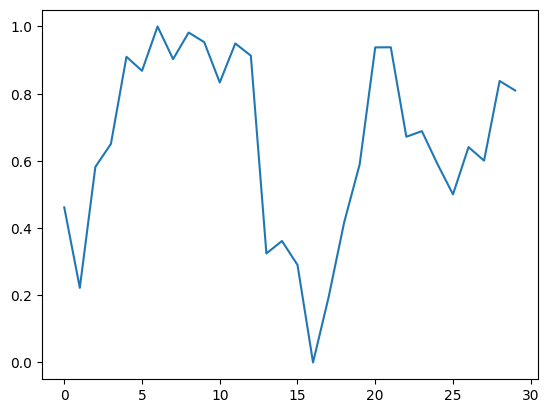

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
time_period = 1
num_classes = 1

model = keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(tf.keras.layers.AveragePooling1D(5))

model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(tf.keras.layers.AveragePooling1D(5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1, ))#activation = 'softmax'))


##adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)
adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, amsgrad=False)


#model.compile(loss='mse',
#                optimizer=adam)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["accuracy"],
)

print(model.summary())


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_34. Consider increasing the input size. Received input shape [None, 2, 20] which would produce output shape with a zero or negative value in a dimension.

In [44]:
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=500,
                    verbose=1,
                    validation_split=0.1,
                    #callbacks=[get_best_model]
                   )

Epoch 1/500
6/6 [==============================] - 2s 46ms/step - loss: 0.6772 - accuracy: 0.0000e+00 - val_loss: 0.0627 - val_accuracy: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 16ms/step - loss: 0.1748 - accuracy: 0.0000e+00 - val_loss: 0.0332 - val_accuracy: 0.0000e+00
Epoch 3/500
6/6 [==============================] - 0s 17ms/step - loss: 0.1042 - accuracy: 0.0000e+00 - val_loss: 0.1031 - val_accuracy: 0.0000e+00
Epoch 4/500
6/6 [==============================] - 0s 16ms/step - loss: 0.0911 - accuracy: 0.0000e+00 - val_loss: 0.0189 - val_accuracy: 0.0000e+00
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0763 - accuracy: 0.0000e+00 - val_loss: 0.0254 - val_accuracy: 0.0000e+00
Epoch 6/500
6/6 [==============================] - 0s 15ms/step - loss: 0.0625 - accuracy: 0.0000e+00 - val_loss: 0.0306 - val_accuracy: 0.0000e+00
Epoch 7/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0512 - accuracy: 0.0000e+00 - val_loss

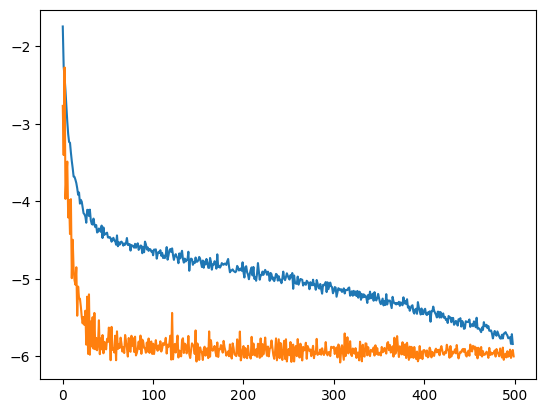

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [46]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

43/43 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='date'>

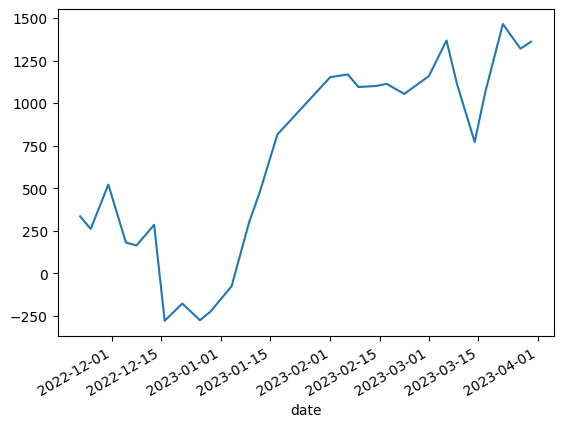

In [47]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2022':].cumsum()
eq.plot()

In [48]:
signal['2022':].astype(int).diff().abs().sum()

1.0

In [49]:
eq.tail()

date
2023-03-17    1064.06
2023-03-22    1465.31
2023-03-27    1320.37
2023-03-30    1361.38
2023-04-07        NaN
Name: 台股指數, dtype: float64

In [65]:
# 預測所有日期的漲跌幅度
predicted_returns = model.predict(cnn_x)



TypeError: predict() missing 1 required positional argument: 'x'

In [77]:
import numpy as np

# 預測所有測試資料的機率
pred_probs = model.predict(cnn_x)

# 找出所有機率大於 0.5 的日期
trigger_dates = np.where(pred_probs > 0.5)[0]

# 印出觸發訊號的日期
print("Trigger dates:", trigger_dates)


44/44 [==============================] - 0s 972us/step
Trigger dates: [   0    3    4    5   22   24   25   35   36   36   37   38   46   54
   58   71   72   78   79   79   80   82   83   84   86   87   88   89
   90   97   98   99  100  122  124  125  132  138  139  140  140  141
  141  142  143  144  144  145  146  147  155  156  161  162  172  181
  182  183  183  184  184  185  191  192  211  212  215  231  238  239
  241  250  251  264  270  271  272  273  273  274  274  275  276  276
  277  288  289  290  290  291  299  300  301  301  302  303  307  308
  309  309  310  311  315  316  317  317  318  326  327  328  328  329
  329  330  330  331  332  340  346  347  348  349  350  353  354  364
  365  366  369  375  376  377  385  386  386  387  387  388  388  389
  389  395  396  397  397  398  398  404  405  407  416  417  418  423
  425  430  431  434  435  436  436  437  437  438  438  443  444  445
  451  452  454  454  455  455  456  456  457  458  465  466  467  474
  475  

In [74]:
model.predict(cnn_x)

44/44 [==============================] - 0s 630us/step


array([[[0.        , 0.        , 0.08145648, ..., 0.04195368,
         0.        , 0.17208152],
        [0.        , 0.        , 0.18548295, ..., 0.14414114,
         0.01517125, 0.03831982]],

       [[0.        , 0.        , 0.15688923, ..., 0.07155218,
         0.01517125, 0.06547904],
        [0.00796609, 0.        , 0.11739951, ..., 0.22853461,
         0.        , 0.11433506]],

       [[0.        , 0.        , 0.17347154, ..., 0.17295071,
         0.01517125, 0.06329477],
        [0.02645365, 0.        , 0.01775072, ..., 0.1694705 ,
         0.04983767, 0.13680334]],

       ...,

       [[0.01738844, 0.        , 0.0646074 , ..., 0.13647804,
         0.06594811, 0.09391319],
        [0.01633402, 0.        , 0.00937572, ..., 0.19462624,
         0.01563505, 0.12928471]],

       [[0.02723116, 0.        , 0.02046479, ..., 0.17879054,
         0.04051114, 0.08116931],
        [0.        , 0.        , 0.03157176, ..., 0.07527764,
         0.        , 0.1504571 ]],

       [[0.007971

In [52]:
predicted_returns_list = signal_dates.tolist()
predicted_returns_list

[Timestamp('2006-10-24 00:00:00'),
 Timestamp('2006-10-27 00:00:00'),
 Timestamp('2006-11-01 00:00:00'),
 Timestamp('2006-11-06 00:00:00'),
 Timestamp('2006-11-09 00:00:00'),
 Timestamp('2006-11-14 00:00:00'),
 Timestamp('2006-11-17 00:00:00'),
 Timestamp('2006-11-22 00:00:00'),
 Timestamp('2006-11-27 00:00:00'),
 Timestamp('2006-12-13 00:00:00'),
 Timestamp('2006-12-18 00:00:00'),
 Timestamp('2006-12-21 00:00:00'),
 Timestamp('2006-12-26 00:00:00'),
 Timestamp('2006-12-29 00:00:00'),
 Timestamp('2007-01-04 00:00:00'),
 Timestamp('2007-01-12 00:00:00'),
 Timestamp('2007-01-17 00:00:00'),
 Timestamp('2007-01-22 00:00:00'),
 Timestamp('2007-01-25 00:00:00'),
 Timestamp('2007-01-30 00:00:00'),
 Timestamp('2007-03-06 00:00:00'),
 Timestamp('2007-03-09 00:00:00'),
 Timestamp('2007-03-14 00:00:00'),
 Timestamp('2007-09-03 00:00:00'),
 Timestamp('2007-09-06 00:00:00'),
 Timestamp('2007-09-11 00:00:00'),
 Timestamp('2009-01-20 00:00:00'),
 Timestamp('2009-02-03 00:00:00'),
 Timestamp('2009-02-

In [ ]:
print(indexes[-10:])